In [2]:
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
VERSION = 4

### Load Data

In [3]:
df_joint_train = pd.read_csv(f'./features/cache_all_features_train_V4.csv')

print("shape of train set: ", df_joint_train.shape)

shape of train set:  (10981, 1550)


In [12]:
df_joint_train_aug = pd.read_csv(f'./dataset/splitted/cache_all_features_augenmented_train_data_v4_1547features.csv')
feature_column_names = [i for i in df_joint_train.columns \
                        if i not in ['file_path','renamed_file_path','split','sentiment_value','emotional_category']]

df_joint_test = pd.read_csv(f'./features/cache_all_features_test_V{VERSION}.csv')

print("shape of train set: ", df_joint_train_aug.shape)
print("shape of test  set: ", df_joint_test.shape)

shape of train set:  (13904, 1547)
shape of test  set:  (1180, 1550)


In [13]:
X_train = df_joint_train[feature_column_names]
y_train_s = df_joint_train['sentiment_value']
y_train_e = df_joint_train['emotional_category']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_e_num = label_encoder.fit_transform(y_train_e)

X_test = df_joint_test[feature_column_names]
y_test_s = df_joint_test['sentiment_value']
y_test_e = df_joint_test['emotional_category']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_test_e_num = label_encoder.fit_transform(y_test_e)

In [9]:
### generate selected features 
# PREFIXES = {'mfcc': 60,'chroma': 12, 'mel32': 32, 'mel64': 64,'mel128': 128, 'zcr': 1, 'rms': 1}
def generate_selected_features_by_type(feature_column_names,input,stats,number=1):
    selected_result = []
    for name in feature_column_names:
        if input+"_"+stats in name:
            selected_result.append(name)
    if number < len(selected_result):
        selected_result = selected_result[:number]
    return selected_result

# example to take mfcc 20 mean & std; mel32; zcr all 5 stats features
feature_MFCC20_mean = generate_selected_features_by_type(feature_column_names,"mfcc","mean",20)
feature_MFCC20_std  = generate_selected_features_by_type(feature_column_names,"mfcc","std",20)
feature_mel32_stats = generate_selected_features_by_type(feature_column_names,"mel32","",32*5)
feature_zcr_stats   = generate_selected_features_by_type(feature_column_names,"zcr","",5)
feature_rms_stats   = generate_selected_features_by_type(feature_column_names,"rms","",5)

In [10]:
# # REF: previous study selected prosody features
selected_spect = ['Spectrum_band_energy_difference','Spectrum_band_density_difference','Spectrum_center_of_gravity_spectrum','Spectrum_skewness_spectrum','Spectrum_kurtosis_spectrum', 'Spectrum_stddev_spectrum','Spectrum_band_density', 'Spectrum_band_energy']
selected_formant = ['Formant_f1_mean','Formant_f1_median','Formant_f3_mean','Formant_fitch_vtl','Formant_mff','Formant_formant_dispersion']
selected_GNE = ['GNE_max_gne', 'GNE_stddev_gne', 'GNE_mean_gne', 'GNE_sum_gne']
selected_pitch = ['Pitch_pitch_slope_without_octave_jumps', 'Pitch_q3_pitch','Pitch_stddev_pitch', 'Pitch_mean_absolute_pitch_slope','Pitch_mean_pitch', 'Pitch_max_pitch', 'Pitch_q1_pitch', 'Pitch_min_pitch']
selected_intensity = ['Intensity_max_intensity', 'Intensity_q3_intensity','Intensity_median_intensity', 'Intensity_mean_intensity', 'Intensity_stddev_intensity','Intensity_relative_max_intensity_time']
selected_HNR = ['HNR_stddev_hnr', 'HNR_mean_hnr','HNR_relative_min_hnr_time','HNR_max_hnr']
selected_prosody = selected_spect + selected_formant + selected_HNR + selected_intensity + selected_pitch + ['Local Jitter','Local Shimmer']

## Experiments

In [14]:
# Example try MFCC 20 mean & std + ZCR & RMS
# feature_column_names = feature_MFCC20_mean + feature_MFCC20_std + feature_zcr_stats + feature_rms_stats
feature_column_names = selected_prosody

X_train = df_joint_train[feature_column_names]
X_test = df_joint_test[feature_column_names]

### Sentiment 3-class Decision Tree Classifier

In [15]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train_s)
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_s,predictions))

              precision    recall  f1-score   support

          -1       0.78      0.78      0.78       748
           0       0.57      0.57      0.57       183
           1       0.54      0.54      0.54       249

    accuracy                           0.70      1180
   macro avg       0.63      0.63      0.63      1180
weighted avg       0.70      0.70      0.70      1180



### Sentiment 3-class Random Forest Classifier

              precision    recall  f1-score   support

          -1       0.75      0.96      0.84       748
           0       0.81      0.48      0.60       183
           1       0.89      0.43      0.58       249

    accuracy                           0.77      1180
   macro avg       0.82      0.62      0.68      1180
weighted avg       0.79      0.77      0.75      1180

[[717  19  12]
 [ 95  87   1]
 [140   1 108]]


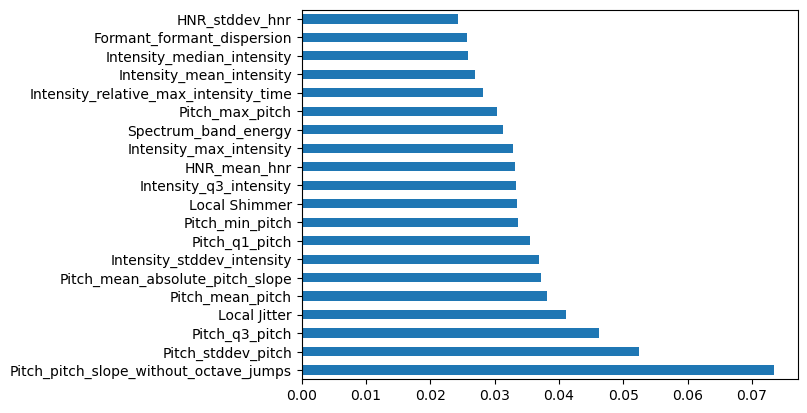

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train_s)
predictions = rand_forest.predict(X_test) 
# Evaluate the model
print(classification_report(y_test_s, predictions))
print(confusion_matrix(y_test_s, predictions))
# Visualize feature importances
feature_importances = pd.Series(rand_forest.feature_importances_, index=X_train.columns)
feature_importances.nlargest(20).plot(kind='barh')
plt.show()

In [18]:
# # if you want to adjust the threshold 
# Predict probabilities for each class label
probabilities = rand_forest.predict_proba(X_test)

In [19]:
probabilities

array([[0.66, 0.28, 0.06],
       [0.87, 0.07, 0.06],
       [1.  , 0.  , 0.  ],
       ...,
       [0.96, 0.04, 0.  ],
       [0.9 , 0.1 , 0.  ],
       [0.97, 0.02, 0.01]])

In [20]:
# Calculate accuracy for the given threshold
from sklearn.metrics import precision_recall_fscore_support
def calc_acc_by_thres(probabilities, threshold, y_test):
    predictions_adj = []
    # Loop through each sample's probabilities
    for probs in probabilities:
        if probs[0] > threshold:
            pred_class = -1
        elif probs[1] > probs[2]:
            pred_class = 0
        else:
            pred_class = 1
        predictions_adj.append(pred_class)
    accuracy = np.mean(predictions_adj == y_test)
    precision, recall, f1score, _ = precision_recall_fscore_support(y_test_s, predictions_adj, average=None)
    return accuracy, min(f1score), np.var(f1score)

best_threshold = None
best_accuracy = 0.0
best_f1score = 0.0
# best_f1s_var = 10

# Define a range of threshold values to try
threshold_range = np.linspace(0.25, 0.75, 100)
for threshold in threshold_range:
    accuracy, min_f1_score, var_f1_score = calc_acc_by_thres(probabilities, threshold, y_test_s)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
        best_f1score = min_f1_score
    # if min_f1_score > best_f1score:
    #     best_f1score = min_f1_score
    #     best_threshold = threshold
    #     best_accuracy = accuracy
    # if var_f1_score < best_f1s_var:
    #     best_f1score = min_f1_score
    #     best_threshold = threshold
    #     best_accuracy = accuracy
    #     best_f1s_var = var_f1_score
        

print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)
print("Best min f1 score:", best_f1score)
# print("Best var f1 score:", best_f1s_var)

Best Threshold: 0.5126262626262627
Best Accuracy: 0.785593220338983
Best min f1 score: 0.635


Best Threshold: 0.643939393939394
Best Accuracy: 0.7601694915254237
Best min f1 score: 0.6577777777777778  
Best Threshold: 0.5025252525252526
Best Accuracy: 0.7889830508474577
Best min f1 score: 0.6138107416879796

In [13]:
print('threshold 0.5025') 
threshold = 0.5328 

predictions_adj = []
for probs in probabilities:
    if probs[0] > threshold:
        pred_class = -1
    elif probs[1] > probs[2]:
        pred_class = 0
    else:
        pred_class = 1
    predictions_adj.append(pred_class)
print(classification_report(y_test_s, predictions_adj))
print(confusion_matrix(y_test_s, predictions_adj))
print("Accuracy:", np.mean(predictions_adj == y_test_s))

print('threshold 0.6439') 
threshold = 0.6237
predictions_adj = []
for probs in probabilities:
    if probs[0] > threshold:
        pred_class = -1
    elif probs[1] > probs[2]:
        pred_class = 0
    else:
        pred_class = 1
    predictions_adj.append(pred_class)
print(classification_report(y_test_s, predictions_adj))
print(confusion_matrix(y_test_s, predictions_adj))
print("Accuracy:", np.mean(predictions_adj == y_test_s))

threshold 0.5025
              precision    recall  f1-score   support

          -1       0.80      0.91      0.85       748
           0       0.67      0.64      0.66       183
           1       0.82      0.52      0.63       249

    accuracy                           0.78      1180
   macro avg       0.76      0.69      0.71      1180
weighted avg       0.79      0.78      0.78      1180

[[679  45  24]
 [ 60 118   5]
 [108  12 129]]
Accuracy: 0.7847457627118644
threshold 0.6439
              precision    recall  f1-score   support

          -1       0.86      0.80      0.83       748
           0       0.57      0.79      0.66       183
           1       0.68      0.62      0.65       249

    accuracy                           0.76      1180
   macro avg       0.70      0.74      0.71      1180
weighted avg       0.77      0.76      0.76      1180

[[599  85  64]
 [ 31 144   8]
 [ 70  24 155]]
Accuracy: 0.7610169491525424


In [ ]:
precision, recall, f1score, _ = precision_recall_fscore_support(y_test_s, predictions_adj, average=None)

metrics_dict = {}
for i in range(len(precision)):
    class_label = f"class_{i-1}"
    metrics_dict[f"{class_label}_precision"] = round(precision[i],3)
    metrics_dict[f"{class_label}_recall"] = round(recall[i],3)
    metrics_dict[f"{class_label}_f1score"] = round(f1score[i],3)

print(metrics_dict)

In [ ]:
misclassified_indices = []
print('threshold 0.6237') 
# Iterate over each sample's probabilities and corresponding true label
for i, (pred_class, true_label) in enumerate(zip(predictions_adj, y_test_s)):
    if pred_class != true_label:
        misclassified_indices.append(i)

print("Misclassified Data Points:")
for index in misclassified_indices:
    if y_test_s[index] == 1: 
        print(f"Index: {index}, Predicted Label: {predictions_adj[index]}, True Label: {y_test_s[index]}")
        print(f"Data:", df_joint_test[df_joint_test.index==index])
        break
